In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.dis = nn.Sequential(
                      nn.Linear(784,512),
                      nn.LeakyReLU(0.2),
                      nn.Linear(512,256),
                      nn.LeakyReLU(0.2),
                      nn.Linear(256,1),
                      nn.Sigmoid()
                      )

    def forward(self,x):
        x = self.dis(x)
        return x

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.gen = nn.Sequential(
                      nn.Linear(128,256),
                      nn.LeakyReLU(0.2),
                      nn.Linear(256,512),
                      nn.LeakyReLU(0.2),
                      nn.Linear(512,784),
                      nn.Tanh()
                      )

    def forward(self,x):
        x = self.gen(x)
        return x

In [6]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
trainset = torchvision.datasets.MNIST(root = './', train = True, download = True,transform = transform)
testset = torchvision.datasets.MNIST(root = './', train = False, download = True,transform = transform)
print(type(trainset))
print(trainset)
print(len(trainset))
print(testset)

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
60000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [7]:
def one_hot(size):
    # tensor containing ones
    data = Variable(torch.ones(size, 1))
    return data

In [8]:
def zero_cold(size):
    # tensor containing zeroes
    data = Variable(torch.zeros(size, 1))
    return data

In [9]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 100, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 100, shuffle = False)

In [10]:
# init generator
generator = Generator()
# init discriminator
discriminator = Discriminator()
# adam optimizer for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
# adam optimizer for generator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
# init loss function
criterion = nn.BCELoss()

In [11]:
def train_generator(optimizer, data):
    # gradient is set to 0
    optimizer.zero_grad()
    # passing through the network
    net_out = discriminator(data)
    # calculaing BCE loss
    loss = criterion(net_out, one_hot(net_out.size(0)))
    # propogating loss at current step
    loss.backward()
    # updating parameters (in steps) after gradient descent
    optimizer.step()
    return loss

In [12]:
def train_discriminator(optimizer, real_data, fake_data):
    # gradient is set to 0
    optimizer.zero_grad()
    # Train/passing through the network on Real Data
    net_out_real = discriminator(real_data)
    # Calculaing BCE loss for real data
    loss_real = criterion(net_out_real, one_hot(real_data.size(0)))
    # propogating loss at current step
    loss_real.backward()

    # passing through the network on Fake Data
    net_out_fake = discriminator(fake_data)
    # calculaing BCE loss for fake data
    loss_fake = criterion(net_out_fake, zero_cold(fake_data.size(0)))
    # propogating loss at current step
    loss_fake.backward()
    
    # updating parameters (in steps) after gradient descent
    optimizer.step()
    
    return loss_real + loss_fake

Epoch: 0 gen loss: 3.2225, disc error: 0.2139
Epoch: 1 gen loss: 3.3166, disc error: 0.6470
Epoch: 2 gen loss: 1.5660, disc error: 2.5703
Epoch: 3 gen loss: 2.3452, disc error: 0.7520
Epoch: 4 gen loss: 2.9636, disc error: 0.2332
Epoch: 5 gen loss: 2.2618, disc error: 0.4082
Epoch: 6 gen loss: 3.3198, disc error: 0.3895
Epoch: 7 gen loss: 2.8535, disc error: 0.9181
Epoch: 8 gen loss: 3.8854, disc error: 0.3373
Epoch: 9 gen loss: 3.6317, disc error: 0.2777
Epoch: 10 gen loss: 2.7346, disc error: 0.4660
Epoch: 11 gen loss: 2.5575, disc error: 0.4683
Epoch: 12 gen loss: 2.6586, disc error: 0.4671
Epoch: 13 gen loss: 1.8185, disc error: 1.0224
Epoch: 14 gen loss: 2.7068, disc error: 0.4956
Epoch: 15 gen loss: 3.4080, disc error: 0.8111
Epoch: 16 gen loss: 3.0900, disc error: 0.6306
Epoch: 17 gen loss: 2.5745, disc error: 0.5762
Epoch: 18 gen loss: 2.2716, disc error: 0.6278
Epoch: 19 gen loss: 2.9346, disc error: 0.7531
Epoch: 20 gen loss: 2.6518, disc error: 0.6046
Epoch: 21 gen loss: 1.9

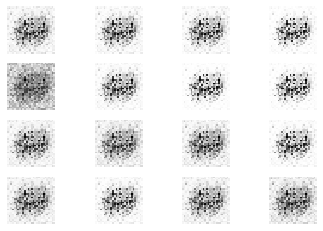

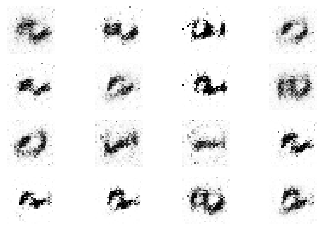

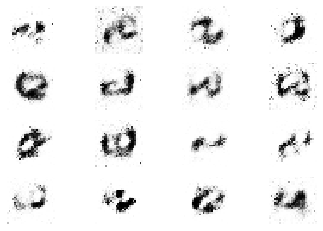

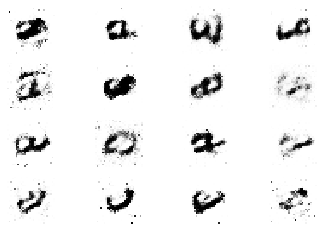

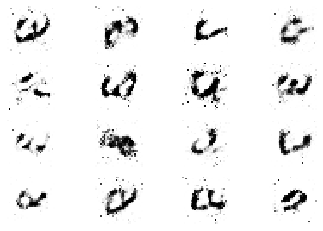

In [15]:
generator_error = []
discriminator_error = []
epochs = 50
for epoch in range(0,epochs):
    total_gen_error = 0
    total_disc_error = 0
    for batchId, (data,_)  in enumerate(train_loader,0):
        data = Variable(data.view(data.size(0), 784))
        noise = Variable(torch.randn(data.size(0), 128))
#         print(type(data))
#         print(type(noise))
#         print(noise.shape)
#         print(data.shape)

        # Generate fake data
        fake_data = generator(Variable(torch.randn(data.size(0), 128))).detach()

        # Train Discriminator
        disc_error = train_discriminator(d_optimizer, data, fake_data)
        
        # Generate fake data
        fake_data = generator(Variable(torch.randn(data.size(0), 128)))
        
        # Train Generator
        gen_error = train_generator(g_optimizer, fake_data)
        
        total_gen_error += gen_error
        total_disc_error += disc_error
    print('Epoch: {} gen loss: {:.4f}, disc error: {:.4f}'.format(
        epoch, gen_error, disc_error))
#     print(total_gen_error)
#     print(total_disc_error)
    generator_error.append(total_gen_error.item()/batchId)
    discriminator_error.append(total_disc_error.item()/batchId)
    if (epoch) % 10 == 0:
        num_of_images = 16
        images = generator(Variable(torch.randn(num_of_images, 128)))
        images = images.view(images.size(0), 1, 28, 28)
        
        figure = plt.figure()
        # _, axes = plt.subplots(1,2)
        for index in range(0, num_of_images):
            plt.subplot(4, 4, index+1)
            plt.imshow(np.moveaxis(images[index].detach().numpy().squeeze(), 0, -1), cmap='gray_r')
            plt.axis('off')
            plt.savefig(fname='gan_{}.png'.format(epoch),format='png')

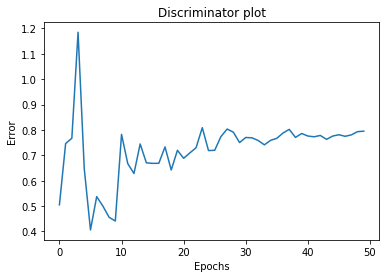

In [16]:
plt.plot(discriminator_error,label="Discriminator")
plt.title("Discriminator plot")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.savefig(fname='gan_disc.png',format='png')

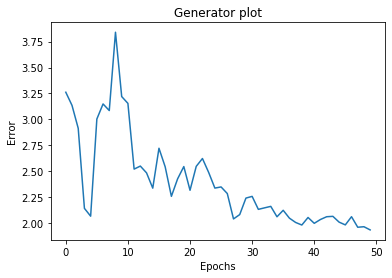

In [17]:
plt.plot(generator_error,label="Generator")
plt.title("Generator plot")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.savefig(fname='gan_gen.png',format='png')

In [18]:
torch.save(generator, "hw5_gan_gen.pth")
torch.save(discriminator, "hw5_gan_dis.pth")